# Average Lunar Temperature Brightness Simulation

## Import Packages

In [1]:
# import packages
import numpy as np
from tqdm import tqdm
import cupy as cp # cupy-cuda12x 13.4.0

## Define Functions

### Lunar Facet Area

In [2]:
def lunar_facets_areas(moon_radius):
    """
    Compute the surface area of every 1° × 1° facet on a spherical Moon.

    The Moon is treated as a perfect sphere of radius ``moon_radius``.  
    Integer-degree meridians (−180° … +180°) and parallels (−90° … +90°) are
    taken as cell *edges*.  For the quadrangle bounded by

        (λ_k , φ_j)  →  (λ_{k+1}, φ_{j+1})  with Δλ = 1°,

    the exact spherical area is

        A = R² · Δλ · (sin φ_{j+1} − sin φ_j) [m²].

    The routine evaluates that expression for every latitude–longitude pair,
    returning a CuPy array of shape ``(360, 180)``  
    (360 longitude cells × 180 latitude cells).

    Parameters
    ----------
    moon_radius : float
        Mean radius of the Moon [m].

    Returns
    -------
    facet_areas : cupy.ndarray, shape (360, 180)
        Area of each 1° × 1° facet in square metres.  
        Indexing convention:

        * ``facet_areas[i, j]`` spans longitudes  
          λ ∈ [−180° + i·1°, −179° + i·1°]  
          and latitudes  
          φ ∈ [−90° + j·1°, −89° + j·1°].

        * The facet centre therefore lies at  
          (λ_c , φ_c) = (−179.5° + i,  −89.5° + j).

    Notes
    -----
    * CuPy must be imported as ``cp``; swap to ``numpy`` for a CPU-only version.
    * A quick sanity check is that the sum of all facet areas should equal
      4 π R² to machine precision.

    Examples
    --------
    >>> import cupy as cp
    >>> R_MOON = 1_737_400        # metres
    >>> areas = lunar_facets_areas(R_MOON)
    >>> areas.shape
    (360, 180)
    >>> cp.abs(areas.sum() - 4*cp.pi*R_MOON**2) < 1e-4
    True
    """
    # Define ranges for phase, longitude, latitude, and declination
    longitude_array= cp.arange(-180, 181) # setting longitude range in degrees
    latitude_array = cp.arange(-90, 91) # setting latitude range in degrees, (0,90 exclusive) I'm considering the centre point of each facet
    
    # Convert latitude and longitude arrays from degrees to radians
    latitudes = cp.radians(latitude_array)
    longitudes = cp.radians(longitude_array)
 
    # Compute the areas of the facets
    facet_areas = (moon_radius**2) * cp.abs(-1* cp.sin(latitudes[cp.newaxis, 1:]) + cp.sin(latitudes[cp.newaxis, :-1])) * (longitudes[1:, cp.newaxis] - longitudes[:-1, cp.newaxis])
    
    return facet_areas

### Solar Zenith Angle

In [3]:
def calculate_zenith_angle(phase):
    """
    Solar-zenith angle for every 1° × 1° facet on the Moon at a
    given selenographic phase angle.

    A facet is identified by its centre longitude (λ) (−179.5° … +179.5°,
    360 cells) and centre latitude (φ) (−89.5° … +89.5°, 180 cells).
    Assuming the Sun’s declination relative to the lunar equator is zero
    (δ = 0°), the cosine of the solar-zenith angle ζ is

        cos ζ = sin δ · sin φ  +  cos δ · cos φ · cos(λ + Φ),

    where Φ is the “lunar phase angle” measured westward from the
    sub-solar point on the lunar equator (Φ = 0° ⇒ Full Moon, 
    Φ = 90° ⇒ First Quarter, Φ = 180° ⇒ New Moon, Φ = 270° ⇒ Third Quarter).
    The function returns ζ in radians.

    Parameters
    ----------
    phase : float or 1-D cupy.ndarray
        Lunar phase angle(s) in degrees.  A scalar phase yields one
        2-D zenith-angle map; a vector of length P yields a 3-D array
        with an extra phase axis.

    Returns
    -------
    zenith_angle : cupy.ndarray
        * If `phase` is a scalar → shape (360, 180) 
          (longitude index, latitude index).
        * If `phase` has shape (P,) → shape (360, P, 180)
          (longitude, phase, latitude).

        All values are in radians and lie in the range 0 ≤ ζ ≤ π.

    Notes
    -----
    * Longitude increases eastward, latitude positive northward.
    * The centres of the facets are offset by +0.5° so the zenith angle is
      computed at the facet centroid rather than at its edges.
    * With δ = 0° the sub-solar point always lies on the lunar equator; if
      you need the real solar declination, supply it as an extra argument
      and replace the hard-wired `declination = 0`.

    Examples
    --------
    >>> import cupy as cp
    >>> zen = calculate_zenith_angle(90)        # First-quarter Moon
    >>> zen.shape
    (360, 180)
    >>> phases = cp.arange(0, 360, 10)
    >>> zen = calculate_zenith_angle(phases)    # stack of 36 phase maps
    >>> zen.shape
    (360, 36, 180)
    """
    
    half_deg = 0.5 # half degree, so that we are calculating the centre of the facets rather than zenith angles along edges
    longitude_edges = cp.arange(-180 + half_deg, 180, 1)# setting longitude range in degrees
    latitude_edges = cp.arange(-90 + half_deg, 90, 1)
    declination = 0
    
    # Convert angles from degrees to radians for numpy trigonometric functions
    phase_rad = cp.radians(phase)

    longitude_rad = cp.radians(longitude_edges)[:, cp.newaxis]  # shape (360, 1)
    latitude_rad = cp.radians(latitude_edges)[cp.newaxis, :]  # shape (1, 180)
    declination_rad = cp.radians(declination)

    # Calculate the zenith angle for all combinations of phase, lon, and lat
    zenith_angle_array = cp.arccos(
        cp.sin(declination_rad) * cp.sin(latitude_rad)
        + cp.cos(declination_rad) * cp.cos(latitude_rad)
        * cp.cos(longitude_rad - phase_rad)
    )

    return zenith_angle_array

### Flux per Facet Centre

In [4]:
def flux_input_func(W_0, zenith_angle_array, albedo):
    """
    Absorbed solar flux on each lunar facet.

    The absorbed irradiance Wₜ (W m⁻²) at a facet whose solar-zenith angle
    is ζ is

        Wₜ = W₀ · cos(ζ) · (1 – a) ,

    where

    * W₀ is the solar constant at the Moon’s distance,
    * a is the albedo,
    * ζ Solar Zenith Angle Array.

    Parameters
    ----------
    W_0 : float or array-like
        Incident solar flux in W m⁻².  May be a scalar or an array
        broadcastable against `zenith_angle_array` (e.g. time dependence).
    zenith_angle_array : cupy.ndarray
        Solar-zenith angle in (radians) for each facet (and/or time step).
        Shape (N_lon, N_lat).
    albedo : float or array-like
        Dimensionless lunar albedo 0 ≤ a ≤ 1.  Scalar or array broadcastable
        to the shape of `zenith_angle_array`.

    Returns
    -------
    W_t : cupy.ndarray
        Absorbed solar flux (W m⁻²) with the same shape as
        `zenith_angle_array`.

    Notes
    -----
    * Negative cosines (night-side facets) are clipped to zero so no
      unphysical “negative heating” is introduced.
    * The routine is fully vectorised; supply CuPy arrays for GPU execution
      or swap `cp` → `np` for CPU NumPy.

    Examples
    --------
    >>> import cupy as cp
    >>> W0      = 1361 * (1/1.017)**2          # W m⁻² at lunar aphelion
    >>> zeta    = cp.linspace(0, cp.pi, 5)     # 0° … 180°
    >>> result  = flux_input_func(W0, zeta, albedo=0.15)
    >>> result[0] > 0 and result[-1] == 0      # day-side vs. night-side
    True
    """
    # Calculate the heat input based on the zenith angle
    W_t = W_0 * cp.clip(cp.cos(zenith_angle_array), 0, None) * (1 - albedo)

    # W/m^2 = W/m^2 * C * C
    
    return W_t

### Thermal Energy Transfer Functions

#### Surface Layer

In [5]:
def rate_of_change_surface_thermal_energy_func(flux_input_array, area_of_facets, T_0, T_1, sigma, BasCond, tau):
    """
    Rate of change of thermal energy in the uppermost regolith slice.

    For each facet the net power absorbed ( dQ₀/dt ) in the surface layer of
    thickness τ is

    dQ₀/dt = A · ( W_in − σ T₀⁴ )           # radiative balance
           + k · A · (T₁ − T₀) / τ          # conductive flux from below

    where

    * W_in  = absorbed solar-flux density (W m⁻²)  
      (already includes the cosine-projection and albedo term),
    * A    = facet area (m²),
    * σ     = Stefan–Boltzmann constant (W m⁻² K⁻⁴),
    * k     = basalt thermal conductivity (W m⁻¹ K⁻¹),
    * τ     = thickness of the surface slice (m).

    Parameters
    ----------
    flux_input_array : cupy.ndarray or numpy.ndarray
        Absorbed solar flux density (W m⁻²) for every facet (shape
        (N_lon, N_lat)).
    area_of_facets : float or array-like
        Facet area (m²).  Broadcastable to the shape of `flux_input_array`.
    T_0 : array-like
        Surface temperature K (same shape as `flux_input_array`).
    T_1 : array-like
        Temperature of the first subsurface slice K (same shape).
    sigma : float
        Stefan–Boltzmann constant (default 5.670 374 419 e-8 W m⁻² K⁻⁴).
    BasCond : float
        Basalt thermal conductivity (W m⁻¹ K⁻¹).
    tau : float
        Thickness of the surface slice (m) (default 0.01 m ≡ 1 cm).

    Returns
    -------
    dQ0_dt : same type as `flux_input_array`
        Net power absorbed by the surface slice (W);
        shape identical to `flux_input_array`.

    Notes
    -----
    * Negative radiative terms (surface emitting more than it absorbs) are
      handled naturally—no clipping is applied here.
    * The calculation is fully vectorised; pass CuPy arrays for GPU
      acceleration or NumPy arrays for CPU execution.

    Examples
    --------
    >>> import cupy as cp
    >>> A     = 1.0          # m² facet
    >>> W_in  = cp.asarray([1000.0][0])     # W m⁻²
    >>> T0    = cp.asarray([225.0][0])      # K
    >>> T1    = cp.asarray([225.0][0])      # K
    >>> dQdt  = rate_of_change_surface_thermal_energy_func(
    ...             W_in, A, T0, T1,
    ...             sigma=5.67e-8, BasCond=2.1, tau=0.01)
    >>> float(dQdt) > 0                  # net heat gain
    True
    """
    # Radiative term (absorbed – emitted)
    radiative = area_of_facets * (flux_input_array - sigma * T_0 ** 4)

    # Conductive term (Fourier’s law across thickness tau)
    conductive = BasCond * area_of_facets * (T_1 - T_0) / tau

    dQ0_dt = radiative + conductive

    return dQ0_dt

    # dQ0_dt = (area_of_facets * (flux_input_array - sigma * T_0**4)) + ((T_1 - T_0) * BasCond * (area_of_facets/tau))
    # W = (m^2 * ( W/m^2 - W/m^2/K^4 * K^4)) + ((K - K) * W/m/K * (m^2/m))
    
    # return dQ0_dt

#### Intermediate Layer

In [6]:
def rate_of_change_intermediate_thermal_energy_func(T_np1, T_n, T_nm1, BasCond, area_of_facets, tau):
    """
    Net conductive power into an intermediate regolith slice.

    Given three vertically adjacent temperature fields  
    T_{n-1}, T_n and T_{n+1} (K), the net heat flow into
    slice n is obtained from a finite-difference form of Fourier’s law:

        dQₙ/dt = k · A / τ · ( T_{n+1}  − 2 T_n  +  T_{n-1} )         [W]

    i.e. the discrete second derivative of temperature multiplied by the
    layer conductance (k A/τ).  Positive values represent a gain of
    thermal energy in layer n.

    Parameters
    ----------
    T_np1 : array-like
        Temperature of the deeper slice (n + 1) in kelvin.
    T_n : array-like
        Temperature of the slice being evaluated (n) in kelvin.
    T_nm1 : array-like
        Temperature of the shallower slice (n − 1) in kelvin.
        All three temperature arrays must be broadcast-compatible.
    BasCond : float
        Basalt thermal conductivity k in W m⁻¹ K⁻¹.
    area_of_facets : float or array-like
        Horizontal facet area A in m² (broadcastable).
    tau : float
        Layer thickness (τ) in metres (distance between temperature nodes).

    Returns
    -------
    dQn_dt : same type as inputs
        Net conductive power into layer n in watts;
        shape matches the broadcast result of the temperature arrays.

    Examples
    --------
    >>> import cupy as cp
    >>> k   = 2.1          # W m⁻1 K⁻1
    >>> A   = 1.0          # m²
    >>> dz  = 0.01         # m
    >>> Tm1 = cp.asarray([300.0][0])
    >>> T0  = cp.asarray([260.0][0])
    >>> Tp1 = cp.asarray([225.0][0])
    >>> dQ  = rate_of_change_intermediate_thermal_energy_func(
    ...           Tp1, T0, Tm1, k, A, dz)
    >>> float(dQ) < 0      # heat is leaving the warmer layer above
    True
    """

    # Conductive term for intermediate layer
    dQn_dt = (((T_np1 + T_nm1) - (2 * T_n)) * (BasCond * area_of_facets/tau))
    # W = (((K + K) - (2 * K) * ( W/m/K * m^2/m)
    
    return dQn_dt

#### Deepest Layer

In [7]:
def rate_of_change_final_thermal_energy_func(T_const, T_f, T_nm1, BasCond, area_of_facets, tau):
    """
    Net conductive power into the deepest modelled regolith slice.

    At the bottom of the numerical grid the layer below is assumed to be an
    isothermal temperature T_const.

    dQₙ/dt = k · A / τ · ( T_const  − 2 T_f  +  T_{n-1} )              [W]

    where

    * k       – basalt thermal conductivity (W m⁻¹ K⁻¹)  
    * A       – horizontal facet area (m²)  
    * τ       – layer thickness (m)  
    * T_f     – temperature of the final modelled slice (K)  
    * T_{n-1} – temperature of the slice immediately above (K)  
    * T_const – fixed temperature of the semi-infinite substrate (K)

    Parameters
    ----------
    T_const : float or array-like
        Constant temperature (K) of the substrate below the grid.
    T_f : array-like
        Temperature (K) of the final (deepest) modelled slice.
    T_nm1 : array-like
        Temperature (K) of the slice immediately above the final slice.
    BasCond : float
        Basalt thermal conductivity (k) in W m⁻¹ K⁻¹.
    area_of_facets : float
        Facet area, A, in m² (broadcastable to the shape of T_f).
    tau : float
        Layer thickness τ in metres.

    Returns
    -------
    dQf_dt : same type as T_f
        Conductive power into the final slice, in watts; shape matches
        the broadcast result of the temperature inputs.

    Notes
    -----
    * A positive value indicates heat flowing into the final slice
      (from below or above); a positive value indicates net gain.
    * Fully vectorised for either NumPy (CPU) or CuPy (GPU) arrays.

    Examples
    --------
    >>> import numpy as np
    >>> k       = 2.1        # W m⁻1 K⁻1
    >>> A       = 1.0        # m²
    >>> dz      = 0.01       # m
    >>> T_const = 225.0    # K (constant substrate)
    >>> T_f     = np.array([230.0])
    >>> T_nm1   = np.array([240.0])
    >>> dQ      = rate_of_change_final_thermal_energy_func(
    ...             T_const, T_f, T_nm1, k, A, dz)
    >>> dQ > 0  # heat flowing into the final slice
    True
    """
    # Conductive term at the bottom boundary
    dQf_dt = (((T_const + T_nm1) - (2 * T_f)) * (BasCond * area_of_facets/tau))

    # W = (((K + K) - (2 * K) * ( W/m/K * m^2/m)
    
    return dQf_dt

### Thermal Capacitance

In [8]:
def thermal_capacitance(BasCap, area, tau, density):
    """
    Lumped thermal capacitance of a regolith slice.

    The thermal capacitance, γ, (J K⁻¹) of a homogeneous slab is

        γ = c_p · ρ · A · τ ,

    with

    * c_p (BasCap)  – specific heat capacity (J kg⁻¹ K⁻¹)  
    * ρ  (density) – bulk density (kg m⁻³)  
    * A  (area)    – horizontal facet area (m²)  
    * τ  (tau)     – slice thickness (m)

    Parameters
    ----------
    BasCap : float or array-like
        Specific heat capacity of basalt J kg⁻¹ K⁻¹.
    area : float or array-like
        Facet area m².  May be an array matching your grid.
    tau : float
        Thickness of the slice m (default 0.01 m).
    density : float or array-like
        Bulk density of lunar regolith kg m⁻³ (default 1500 kg m⁻³).

    Returns
    -------
    gamma : same type as area
        Thermal capacitance (J K⁻¹) for each facet; shape follows the
        broadcast rules of NumPy/CuPy.

    Notes
    -----
    * Supplying arrays for BasCap or density allows depth- or
      location-dependent material properties.
    * The function is fully vectorised—works with either NumPy (CPU) or
      CuPy (GPU) arrays.

    Examples
    --------
    >>> import numpy as np
    >>> c_p   = 710.0            # J kg⁻1 K⁻1
    >>> rho   = 1500.0           # kg m⁻3
    >>> A     = np.array([[1.0, 1.2], [0.9, 1.1]])   # m² facets
    >>> dz    = 0.01             # m
    >>> gamma = thermal_capacitance(c_p, A, dz, rho)
    >>> gamma.shape
    (2, 2)
    """
    gamma = BasCap * area * tau * density 
    # J/K = J/kg/K * m^2 * m * kg/ m^3
    
    return gamma

### Time Stability

In [29]:
def time_stability_func(BasCap, rho, tau, BasCond):
    """
    Maximum stable time-step (Δt_max) for an explicit 1-D heat-diffusion update.

    The forward-Euler / centred-difference (FTCS) scheme for vertical
    conduction is conditionally stable.  Von Neumann analysis yields the
    Fourier-number criterion

        Fo = k Δt / (ρ c_p τ²)  ≤  ½   ,

    which rearranges to the largest admissible time-step

        Δt_max = ρ c_p τ² / (2 k).

    This helper returns that value so you can pick a Δt ≤ Δt_max.

    Parameters
    ----------
    BasCap : float
        Specific heat capacity, c_p  (J kg⁻¹ K⁻¹).
    rho : float
        Bulk density, ρ  (kg m⁻³).
    tau : float
        Vertical grid spacing (slice thickness), τ  (m).
    BasCond : float
        Thermal conductivity, k  (W m⁻¹ K⁻¹).

    Returns
    -------
    time_stability : float
        Maximum stable explicit time-step, Δt_max  (seconds).

    Examples
    --------
    >>> c_p   = 630.0      # J kg⁻1 K⁻1
    >>> rho   = 1500.0     # kg m⁻3
    >>> dz    = 0.01       # m
    >>> k     = 2.0        # W m⁻1 K⁻1
    >>> dt_max = time_stability_func(c_p, rho, dz, k)
    >>> round(dt_max, 2)
    23.62
    """
    time_stability = (BasCap * rho * tau**2) / (2 * BasCond * 10)

    # round the value down to the nearest integer
    time_stability = np.floor(time_stability).astype(int)
    
    return time_stability

### Lunar Cycle

In [30]:
def lunar_cycle_func():
    """
    Angular speed of the Moon’s synodic cycle.

    Using the mean synodic month (New-Moon to New-Moon) of 29.53 days,
    the function converts that duration to seconds and returns the rate at
    which the lunar phase angle advances:

        ω = 360° / (29.53 days)   →   degrees per second.

    Returns
    -------
    degrees_per_second : float
        Increment of lunar phase angle in (degrees s⁻¹, ≈ 1.409 × 10⁻³ ° s⁻¹).
    """
    # seconds per lunar cycle
    lunar_cycle_seconds = 29.53 * 24 * 3600

    # number of seconds for phase to advance one degree
    seconds_per_degree = lunar_cycle_seconds / 360

    # fraction of a degrees for phase to advance per second
    degrees_per_second = 1 / seconds_per_degree
    
    return degrees_per_second

### Heat Transfer Model

In [31]:
def heat_transfer_model_func(heat_transfer_array,
                             W_0, albedo, T_const,
                             BasCap, tau, rho,
                             end_time, start_time, initial_phase, BasCond):

    """
    Time-marching 1-D conductive / radiative heat-transfer model for every
    facet of a spherical Moon.

    For each facet (λᵢ , φⱼ) the regolith column is discretised into
    N_layers slabs of equal thickness τ.  At every time step the
    surface energy balance and vertical conduction are updated:

        Surface :  dQ₀/dt = A [ W_in − σ T₀⁴ ] + k · A (T₁ − T₀) / τ
        Middle  :  dQₙ/dt = k · A (Tₙ₊₁ − 2Tₙ + Tₙ₋₁) / τ
        Bottom  :  dQ_f/dt = k · A (T_const − 2T_f + T_{f−1}) / τ

    with temperatures advanced explicitly via

        T_new = T_old + (dQ/dt) · Δt / γ

    where γ = c_p · ρ · A · τ is the lumped thermal capacitance of a slice.

    Parameters
    ----------
    heat_transfer_array : cupy.ndarray
        Initial temperature field K with shape
        (N_lon, N_lat, N_layers).
    W_0 : float
        Solar constant at the Moon’s distance W m⁻².
    albedo : float or array-like
        Bond albedo (dimensionless, 0 – 1).
    T_const : float
        Fixed temperature K of the semi-infinite substrate below the
        model domain.
    BasCap : float
        Basalt specific heat capacity J kg⁻¹ K⁻¹.
    tau : float
        Slice thickness m (default 0.01 m).
    rho : float
        Bulk density of lunar regolith kg m⁻³.
    delta_t: int
        increment of time between each layer evaluation (s).
    end_time : int
        End of the simulation window (s, seconds since start of run).
    start_time : int
        Start of the simulation window (s).
    initial_phase : float
        Starting lunar phase angle (degrees) (see `calculate_zenith_angle`).
    BasCond : float
        Basalt thermal conductivity W m⁻¹ K⁻¹ (default 0.02).

    Returns
    -------
    heat_transfer_array : cupy.ndarray
        Updated temperature field (K) with the same shape as the input,
        holding temperatures at end_time.
    phase : float
        Lunar phase angle (degrees) corresponding to end_time.

    Notes
    -----
    * The routine computes facet areas once at start-up via
      `lunar_facets_areas`; these areas are reused at every step.
    * All heavy arithmetic is vectorised; pass CuPy arrays to exploit a GPU
      or swap `cp`→`np` for CPU execution.
    * Stability criterion: choose Δt small enough to satisfy the explicit
      conduction CFL condition, Δt ≤ (c_p ρ τ²)/(2 k).

    Examples
    --------
    >>> import cupy as cp
    >>> nl, nt = 360, 180
    >>> nz = 100
    >>> T_init = 220.0 + cp.zeros((nl, nt, nz))
    >>> T_final, final_phase = heat_transfer_model_func(
    ...     T_init, W_0=1361, albedo=0.12, T_const=220.0,
    ...     BasCap=710.0, tau=0.01, rho=1500.0,
    ...     delta_t=500, start_time=0, end_time=86_400,
    ...     initial_phase=0.0)
    >>> T_final.shape
    (360, 180, 100)
    """

    # determine the lunar phase per second
    degrees_per_second = lunar_cycle_func()
    
    # calculate the area of lunar facets along lines of latitude/longitude
    area_of_facets = lunar_facets_areas(moon_radius)
    
    # Calculate Thermal Capacitance
    gamma = thermal_capacitance(BasCap, area_of_facets, tau, rho)

    # Determine Stability Requirement
    delta_t = time_stability_func(BasCap, rho, tau, BasCond)

    # set phase object
    phase = initial_phase
    
    for second in range(start_time, end_time, delta_t): # range(start,stop,step)
    # for second in range(0, model_run_time, delta_t): # range(start,stop,step) No tqdm package installed in this env

        # Update the surface layer (T_0)
        T_0 = heat_transfer_array[:,:,0] # (longitude, latitude, depth)
        T_1 = heat_transfer_array[:,:,1]

        zenith_angle_array = calculate_zenith_angle(phase)
        W_t = flux_input_func(W_0, zenith_angle_array, albedo) 

        dQ0_dt = rate_of_change_surface_thermal_energy_func(W_t, area_of_facets, T_0, T_1, sigma, BasCond, tau)
        T_0 += (dQ0_dt * delta_t) / gamma

        # Update intermediate layers
        T_n = heat_transfer_array[:,:,1:-1]  # All intermediate layers

        T_np1 = heat_transfer_array[:,:,2:]  # Next layer in each direction

        T_nm1 = heat_transfer_array[:,:,:-2]  # Previous layer in each direction
        dQn_dt = rate_of_change_intermediate_thermal_energy_func(T_np1, T_n, T_nm1, BasCond, area_of_facets[:,:,cp.newaxis], tau)
        
        T_n += (dQn_dt * delta_t) / gamma[:,:,cp.newaxis]

        # Update the final layer (T_f)
        T_f = heat_transfer_array[:,:,-1]
        T_fm1 = heat_transfer_array[:,:,-2]
        T_nm1 = T_nm1[:,:,-1]
        dQf_dt = rate_of_change_final_thermal_energy_func(T_const, T_f, T_nm1, BasCond, area_of_facets, tau)
        T_f += (dQf_dt * delta_t) / gamma

        # Update the heat transfer array with new temperatures
        heat_transfer_array[:,:,0] = T_0
        heat_transfer_array[:,:,1:-1] = T_n
        heat_transfer_array[:,:,-1] = T_f
            
        phase += degrees_per_second * delta_t # phase_step increment in degrees to account for how much the moon rotates over 354 seconds
        # phase += 0.05 # phase_step increment in degrees to account for how much the moon rotates over 354 seconds

    return heat_transfer_array, phase

### Radio Brightness Temperature

In [32]:
def radio_brightness_temp_func(alpha, T_const, heat_transfer_model_array):
    """
    Calculates the radio brightness temperature profile for lunar soil layers.

    The brightness temperature (χ) at each layer is computed recursively from bottom
    (deepest layer, near constant temperature T_const) to top (surface layer radiating into space),
    using a weighted sum of the temperatures of adjacent layers. This reflects the physical process
    of thermal emission propagating upward through the regolith.

    Formula used (from Lunar Thermal Model documentation):
        χ_n = α * χ_(n+1) + (1 - α) * T_n
    where:
        - χ is the brightness temperature at each layer.
        - α is the weighting factor determined by radio-frequency (RF) attenuation properties.
        - T_const (T*) is the constant base temperature at the deepest layer.
        - T_n is the physical temperature at layer n obtained from heat_transfer_model_array.

    Parameters:
    ----------
    alpha : float
        Weighting factor (0 < α < 1) representing RF attenuation between layers. It defines how much
        each layer’s brightness temperature is influenced by the layer immediately below it.
        A value closer to 1 implies strong dependence on deeper layers, and a smaller value
        suggests stronger influence from the immediate physical temperature of the layer.

    T_const : float
        Constant temperature (Kelvin) at the bottom-most layer of the regolith,
        assumed stable (typically ~constant below ~0.8 m depth).

    heat_transfer_array : cp.ndarray
        3D numpy array of shape (latitude, longitude, depth), representing physical temperatures (Kelvin)
        at different lunar soil layers for each spatial facet. The depth axis (3rd dimension)
        is organized from surface (index 0) to the deepest layer (index -1).

    Returns:
    --------
    chi_0 : cp.ndarray
        2D array of brightness temperatures (Kelvin) at the lunar surface layer (depth = 0),
        representing the radiative temperature emitted into space.

    chi_layers : cp.ndarray
        3D array containing brightness temperatures (Kelvin) for all layers at each facet.
        Same shape as heat_transfer_model_array, with the depth axis ordered from surface (index 0)
        downwards.
    """

    # Step 1: Get the number of layers (depth is the last axis)
    num_layers = heat_transfer_array.shape[2]

    # Step 2: Initialize chi array for brightness temperatures
    chi_layers = cp.zeros_like(heat_transfer_array)

    # Step 3: Compute brightness temperature at the bottom layer (deepest)
    chi_layers[:, :, -1] = alpha * T_const + (1 - alpha) * heat_transfer_array[:, :, -1]

    # Step 4: Recursively calculate brightness temperature upwards through layers
    for n in range(num_layers - 2, -1, -1):
        chi_layers[:, :, n] = alpha * chi_layers[:, :, n + 1] + (1 - alpha) * heat_transfer_array[:, :, n]

    # Step 5: Extract brightness temperature at the surface (top layer)
    chi_0 = chi_layers[:, :, 0]

    return chi_0, chi_layers


### Solid Angle Calculations

In [33]:
def calculate_solid_angles_for_moon(moon_radius, distance_to_earth):
    """
    Calculates solid angles subtended by lunar facets as viewed from Earth,
    accounting for projection (cosine) effects. Only facets facing the Earth are included.

    Parameters:
    - moon_radius : float
        Radius of the Moon in meters.

    - distance_to_earth : float
        Distance from the Moon to the Earth in meters.

    - area_of_facets : cp.ndarray
        2D array of lunar facet areas (m²) corresponding to latitude (0° to 90°) 
        and longitude (-180° to 180°). Shape should match the latitude-longitude grid.

    Returns:
    -------
    solid_angles : cp.ndarray
        2D array (same shape as `area_of_facets`) containing solid angles in steradians.

    Notes:
    ------
    - Solid angle calculation considers both the actual facet area and its geometric projection 
      relative to Earth's viewing direction.
    - Facets not facing Earth (cos(theta) ≤ 0) will have zero solid angle.
    - Ensure the longitude ranges from -180° to 180° and latitude from 0° to 90° to 
      represent one hemisphere. (The other hemisphere can be mirrored.)

    Returns:
        solid_angles : cp.ndarray
            2D array of solid angles subtended by each facet (in steradians).
    """

    area_of_facets = lunar_facets_areas(moon_radius)

    # Define longitude and latitude ranges (degrees)
    half_deg = 0.5
    longitude_centres = cp.arange(-180+half_deg, 180, 1)  # Longitude from -180° to 180°
    latitude_centres = cp.arange(-90+half_deg, 90, 1)       # Latitude from equator to pole

    # Convert latitude and longitude arrays from degrees to radians
    latitudes_rad = cp.radians(latitude_centres)
    longitudes_rad = cp.radians(longitude_centres)

    # Create meshgrid for broadcasting
    lon_grid, lat_grid = cp.meshgrid(longitudes_rad, latitudes_rad)

    # Facet normal vectors (in lunar-centric coordinates)
    x_facet = cp.cos(lat_grid) * cp.cos(lon_grid)
    y_facet = cp.cos(lat_grid) * cp.sin(lon_grid)
    z_facet = cp.sin(lat_grid)

    facet_normals = cp.stack((x_facet, y_facet, z_facet), axis=-1)
    
    # Vector pointing toward Earth along +x axis
    earth_vector = cp.array([1, 0, 0])  # assuming Earth is directly aligned along x

    # Calculate cos(theta) between Earth and facet normals
    cos_theta = cp.dot(facet_normals, earth_vector)

    # Transpose the array
    cos_theta = cos_theta.T

    # Only facets facing Earth (cos_theta > 0) contribute
    cos_theta = cp.clip(cos_theta, 0, 1)

    # Calculate solid angles
    solid_angles = area_of_facets * cos_theta / (distance_to_earth**2)

    return solid_angles

### Radio Flux Density

In [34]:
def radio_flux_density(chi_0, solid_angles, wavelength):
    """
    Calculates the total radio flux density emitted by the lunar disc 
    and the flux density contribution from each individual facet.

    The radio flux density (S) at frequency ν (related to wavelength λ by c = νλ) 
    is computed from brightness temperature (χ₀) and the solid angle (Ω_j) subtended by each facet.

    Formula:
        ΔS_j = (2 k_B χ₀_j / λ²) Ω_j

    Parameters:
    -----------
    chi_0 : cp.ndarray
        2D array of brightness temperatures (Kelvin) at the lunar surface (top layer),
        shape: (latitude, longitude).
        
    solid_angles : cp.ndarray
        2D array of solid angles (steradians) subtended by each lunar facet as viewed from Earth.
        Same shape as `chi_0`.
    
    wavelength : float
        Wavelength of the observed radio emission (meters).

    Returns:
    --------
    total_flux_density : float
        Total radio flux density emitted by the lunar disc (Watts per square meter per Hertz, W·m⁻²·Hz⁻¹).
        
    delta_S : cp.ndarray
        2D array of the flux density contribution from each individual facet (W/m²/Hz).
        Same shape as `chi_0`.

    Notes:
    ------
    - Boltzmann's constant (k_B ≈ 1.380649 × 10⁻²³ J/K) relates brightness temperature to radiative flux.
    - Radio flux density per facet follows the Rayleigh-Jeans approximation:

      Delta S = 2 * k_B * chi_0 * Omega/lambda^2
    """
    
    # Individual flux density contribution (W/m²/Hz)
    delta_S = (2 * k_B * chi_0 * solid_angles) / (wavelength**2)

    # Total flux density (W/m²/Hz)
    total_flux_density = cp.sum(delta_S)

    return total_flux_density, delta_S


### Average Radio Brightness Temperature

In [35]:
def average_radio_brightness_temperature(total_flux_density, wavelength, solid_angle_lunar_disk):
    """
    Calculates the average radio brightness temperature (Kelvin) for the lunar disc 
    based on the total measured radio flux density.

    The average brightness temperature (T_b) provides a single representative temperature
    value derived from the total flux density and the Moon's apparent solid angle in the sky.

    Parameters:
    -----------
    total_flux_density : float
        The total radio flux density emitted by the lunar disc (W/m²/Hz).

    wavelength : float
        Wavelength of the observed radio emission (meters).

    solid_angle_lunar_disk : float
        Total solid angle (steradians) subtended by the lunar disc as seen from Earth.
        Typically Ω₀ ≈ 6.4236 × 10⁻⁵ sr at mean Earth-Moon distance (~384,400 km).

    Returns:
    --------
    average_brightness_temp : float
        Average brightness temperature (Kelvin) of the lunar disc.

    Formula:
    --------
    T_b = S lambda^2/{2 k_B Omega_0

    where:
    - S is the total flux density (W·m⁻²·Hz⁻¹),
    - λ is the wavelength (m),
    - k_B ≈ 1.380649 × 10⁻²³ J/K is Boltzmann's constant,
    - Ω₀ is the solid angle subtended by the Moon (steradians).
    """
    
    # Calculate average brightness temperature (Kelvin)
    average_brightness_temp = (total_flux_density * wavelength**2) / (2 * k_B * solid_angle_lunar_disk)

    return average_brightness_temp

## Average Brightness Temperature vs. Phase Function

In [36]:
T_const = 225# The initial temperature to which all values are set

# creating an array of (longitude, latitude, depth) filled with T_const
heat_transfer_array = cp.full((360, 180, 100), T_const).astype(cp.float64)

# setting constants
sigma = 5.67e-8  # Stefan-Boltzmann constant (W/m²K⁴)
W_0 = 1365.0   # the energy flux from the Sun
albedo = 0.15 # lunar albedo
BasCap = 630.0 #Basalt thermal capacity in J Kg-1.K-1 
rho = 1500 # Lunar regolith density in Kg.m-3
BasCond = 0.02 # Basalt thermal conductivity (W/m·K)
delta_t = 354 # 
moon_radius = 1.737e6  # Radius of the Moon in meters
tau = 0.01 # tau is the thickness of the slice (meters)
alpha = 0.96 # the weighting factor determined by radio-frequency (RF) attenuation properties
moon_radius = 1.737e6  # Radius of the Moon in meters
distance_to_earth = 3.844e8  # Average distance from the Moon to Earth in meters
k_B = 1.38e-23  # Boltzmann constant in J/K
wavelength = 0.015 # wavelength of observation in meters

In [37]:
# Lists to hold outputs
avg_brightness_temperature_list = []
phase_step_list = []
total_flux_density_list = []
tenth_heat_transfer_list = []

# Setting time paramters
start_time = 0
end_time = 0
initial_phase = 0
model_run_time = int(2548800*3) # simulation run time for three months
step_size = int(2548800/ (29.5*2)) # saving resolution of every ~12 hours

# iterative step to save values at the end of each stepsize.
for step in tqdm(range(start_time, model_run_time, step_size)):
    
    end_time += step_size # keeping account of end of simulation time

    # heat_transfer_array calculation itself
    heat_transfer_array, phase = heat_transfer_model_func(heat_transfer_array, W_0, albedo, T_const, BasCap, tau,
                                                          rho, end_time, start_time, initial_phase, BasCond)

    # Deriving the radio_brightness temperature
    chi_0 , chi_layers = radio_brightness_temp_func(alpha, T_const, heat_transfer_array)

    # Calculating the solid angle from each facet
    solid_angles = calculate_solid_angles_for_moon(moon_radius, distance_to_earth)

    # Flux density as a function of area and wavelength
    total_flux_density, delta_S = radio_flux_density(chi_0, solid_angles, wavelength)

    # Total lunar disc solid angle
    solid_angle_lunar_disk = cp.sum(solid_angles)

    # Average brightness temperature function
    avg_brightness_temperature = average_radio_brightness_temperature(total_flux_density, wavelength, 
                                                                      solid_angle_lunar_disk)
    
    # saving those values to lists seen above as lists
    avg_brightness_temperature_list.append(avg_brightness_temperature.get())
    phase_step_list.append(phase)
    total_flux_density_list.append(total_flux_density.get())

    tenth_heat_transfer_list.append(heat_transfer_array[180,90,::10].get())

    # ammend the step sizes and phase
    start_time += step_size
    initial_phase = phase

# convert the lists to numpy arrays
total_flux_density_array = np.array(total_flux_density_list)
avg_brightness_temperature_array = np.array(avg_brightness_temperature_list)
phase_step_array = np.array(phase_step_list)

tenth_heat_transfer_array = np.array(tenth_heat_transfer_list)

100%|████████████████████████████████████████████████████████████████████████████████| 177/177 [02:15<00:00,  1.31it/s]


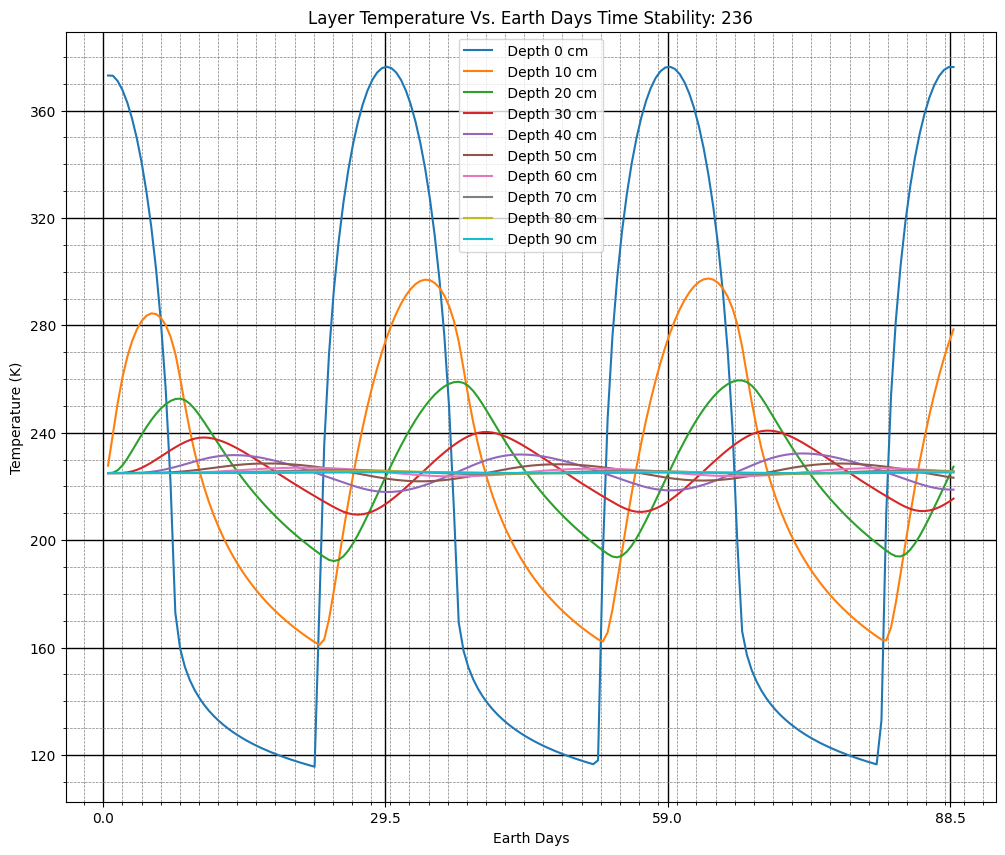

In [38]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure(figsize=(12,10))
for layer in range(10):
    plt.plot((phase_step_array/360)*29.5, tenth_heat_transfer_array[:,layer], label = f" Depth {layer*10} cm")

plt.xlabel("Earth Days")
plt.ylabel("Temperature (K)")
plt.title(f"Layer Temperature Vs. Earth Days Time Stability: {time_stability_func(BasCap, rho, tau, BasCond)}")
ax = plt.gca()

# Set x-axis major ticks to fall exactly at multiples of 29.5
ax.xaxis.set_major_locator(ticker.MultipleLocator(29.5))
# Optionally, choose an interval for minor ticks that fits your needs:
ax.xaxis.set_minor_locator(ticker.MultipleLocator(2))  # 5 minor divisions per major tick

# Set y-axis ticks as before.
ax.yaxis.set_major_locator(ticker.MultipleLocator(40))
ax.yaxis.set_minor_locator(ticker.MultipleLocator(10))

# Apply grid lines: minor (lighter) and major (bolder) ones.
ax.grid(which='minor', linestyle='--', linewidth=0.5, color='gray')
ax.grid(which='major', linestyle='-', linewidth=1.0, color='black')
plt.legend()
# plt.savefig(f"Layer Temperature Vs. Earth Days.png")
plt.show()
